# Attention

## 등장배경
seq2seq 모델은 인코더에서 입력 시퀀스를 context vector라는 고정된 크기의 벡터로 압축하여 디코더에 입력하여 출력 시퀀스를 얻는다.  

이러한 방식은 크게 두 가지의 문제가 발생
1. 고정된 크기의 벡터로 압축하면서 정보 손실 문제
2. RNN의 고질적인 문제인 기울기 소실 문제



## Attention 함수

$$Attention(Q,K,V) = Attention\_ value$$  

Attention은 디코더가 각 출력 시점마다 인코더의 전체 입력 시퀀스를 참고하며 예측을 할 수 있도록 한다.  

어텐션 함수는 디코딩 스텝마다 Query를 계산하여 각 Key와의 유사도를 구하여 Key와 대응되는 Value에 반영하여  
각 스텝마다 연관있는 입력 단어에 집중할 수 있다.  



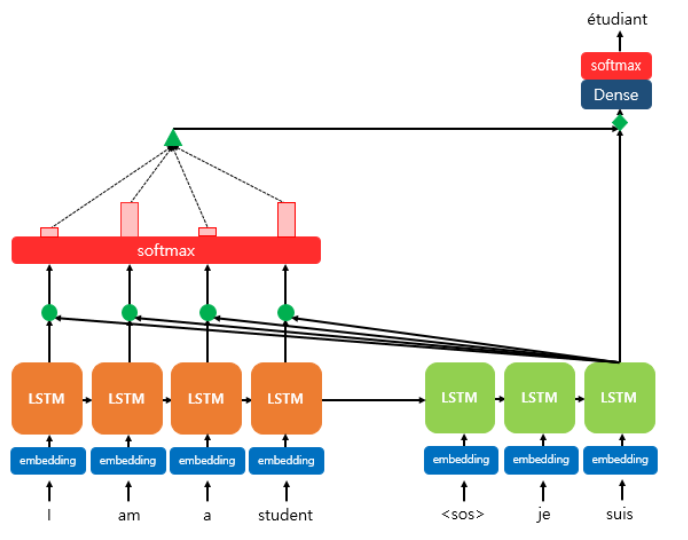

각 Query에 대해서 모든 Key와의 유사도를 구하고 그 값을 어텐션 스코어로 하여 소프트맥스 함수를 통해 어텐션 분포를 구한다.  
구한 어텐션 분포를 가중치로하여 Value를 가중합하여 최종적으로 attention value를 구하고 해당 시점의 hidden state와 concatenate하여 최종 예측 단어를 구한다.

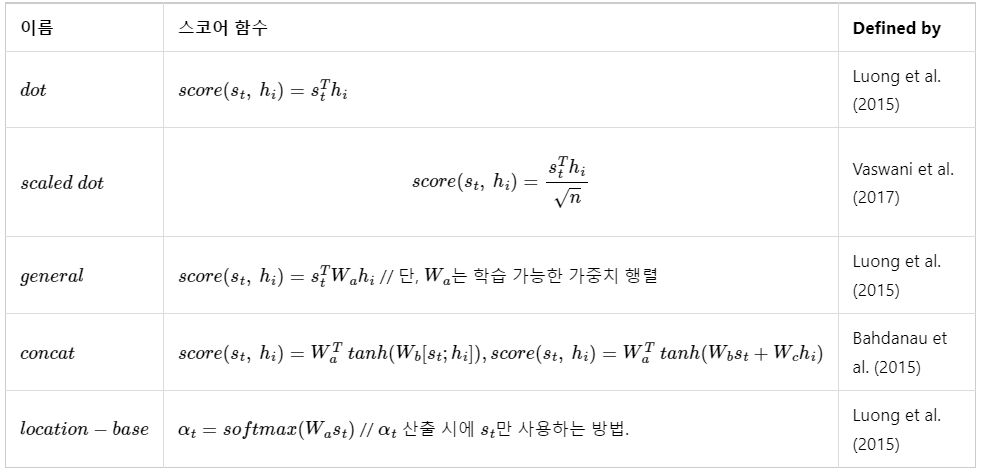

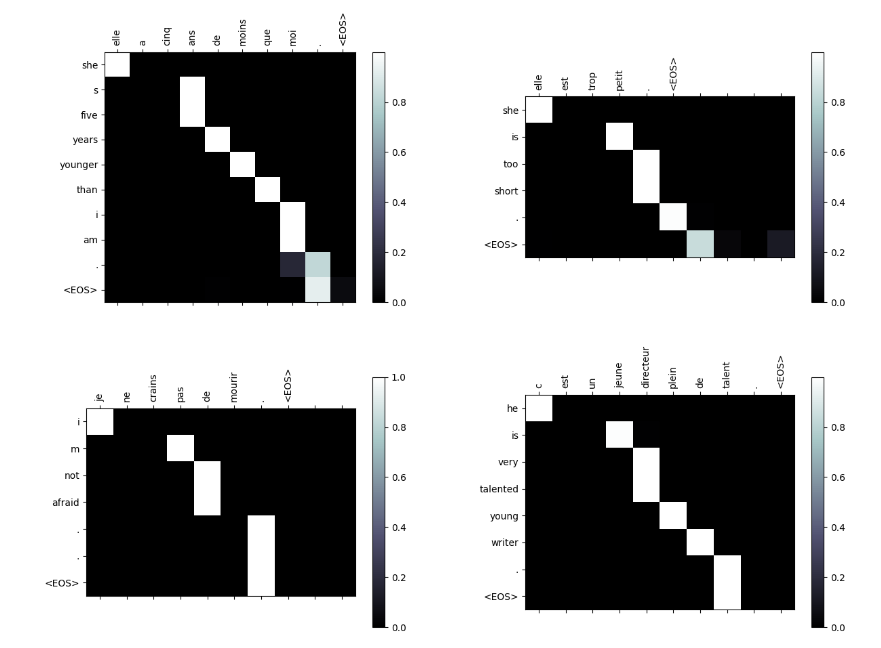

# 코드 실습

## 라이브러리

In [1]:
# 라이브러리
#https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time
import math
import matplotlib.pyplot as plt
plt.rc('font',family='Malgun Gothic')
import matplotlib.ticker as ticker
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 내 드라이브에 패키지 저장하기
import os
import sys
# 실제 코랩 환경에서 패키지들을 모아둘 경로  
my_path = '/content/notebooks'
# 두개의 폴더를 동기화 시켜줌
# (패키지가 설치될 경로(내 드라이브), 코랩 환경에서 패키지를 불러올 경로)
os.symlink('/content/drive/My Drive/Colab Notebooks/packages', my_path)
sys.path.insert(0, my_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
# https://konlpy-ko.readthedocs.io/ko/v0.4.3/install/
import konlpy
from konlpy.tag import Kkma # Mecab 왜 안됨?
from konlpy.tag import Hannanum, Okt, Mecab

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore') 

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
plt.rc('font', family=font_name)
fm._rebuild()
fontprop = fm.FontProperties(fname=path)

## 파라미터 및 데이터 처리 함수

In [3]:
# import unicodedata

# # 경우 1 : 한글 문자열을 자음 모음으로 분리하기
# uni1 = unicodedata.normalize('NFD',temp_str1)

# # 경우 2 : 분리된 자음 모음을 결합하기
# uni2 = unicodedata.normalize('NFC',temp_str2)

# print(uni1) # 자음 모음으로 분리된 형태
# print(uni2) # 자음 모음이 합쳐진 형태

In [13]:
# 데이터 전처리 관련
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 20
teacher_forcing_ratio = 0.5
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

class Lang:
  def __init__(self, name):
    self.name = name
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: "SOS", 1: "EOS"}
    self.n_words = 2  # SOS 와 EOS 포함

  def addSentence(self, sentence):
    for word in sentence.split(' '):
      self.addWord(word)        

  def addWord(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1
    else:
      self.word2count[word] += 1

# 유니 코드 문자열을 일반 ASCII로 변환하십시오.
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
  )

# 소문자, 다듬기, 그리고 문자가 아닌 문자 제거


def normalizeString(s):
  s = unicodeToAscii(s.lower().strip())
  s = re.sub(r"([.!?])", r" \1", s)
  #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
  return s

def readLangs(lang1, lang2, reverse=False):
  print("Reading lines...")

  # 파일을 읽고 줄로 분리
  lines = open('/content/drive/MyDrive/Colab Notebooks/Datasets/kor-eng/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
      read().strip().split('\n')
  
  # 모든 줄을 쌍으로 분리하고 정규화
  pairs = [[normalizeString(s) for s in l.split('\t') ] for l in lines]
  #
  # 쌍을 뒤집고, Lang 인스턴스 생성
  if reverse:
    pairs = [list(reversed(p)) for p in pairs]
    input_lang = Lang(lang2)
    output_lang = Lang(lang1)
  else:
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
  # 한글 처리 ( 한 > 영 변환 )
  if pairs[0][0][0] not in string.ascii_uppercase+string.ascii_lowercase:
    for i in range(len(pairs)):
      pairs[i][0] = unicodedata.normalize('NFC',pairs[i][0])
      pairs[i][0] = ' '.join([word[0] for word in token.pos(pairs[i][0])])

  return input_lang, output_lang, pairs

def filterPair(p):
  return len(p[0].split(' ')) < MAX_LENGTH and \
      len(p[1].split(' ')) < MAX_LENGTH #and p[1].startswith(eng_prefixes)

def filterPairs(pairs):
  return [pair for pair in pairs if filterPair(pair)]


def prepareData(lang1, lang2, reverse=False):
  input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
  print("Read %s sentence pairs" % len(pairs))
  pairs = filterPairs(pairs)
  print("Trimmed to %s sentence pairs" % len(pairs))
  print("Counting words...")
  for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
  print("Counted words:")
  print(input_lang.name, input_lang.n_words)
  print(output_lang.name, output_lang.n_words)
  return input_lang, output_lang, pairs

In [5]:
token = Kkma()
input_lang, output_lang, pairs = prepareData('eng', 'kor', True)
print(random.choice(pairs))

Reading lines...
Read 3853 sentence pairs
Trimmed to 3784 sentence pairs
Counting words...
Counted words:
kor 2794
eng 2672
['더 이상 거짓말 하 지 마 , 알 았 어 ?', "don't lie anymore, ok ?"]


## 모델 정의

In [6]:
# Seq2Seq model

class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)

  def forward(self, input, hidden):
    embedded = self.embedding(input).view(1, 1, -1) # GRU 입력 shape이 3차원
    output = embedded
    output, hidden = self.gru(output, hidden)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size):
    super(DecoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(output_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    output = self.embedding(input).view(1, 1, -1)
    output = F.relu(output)
    output, hidden = self.gru(output, hidden)
    output = self.softmax(self.out(output[0]))
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
    super(AttnDecoderRNN, self).__init__()
    self.hidden_size = hidden_size # 256
    self.output_size = output_size # 2803
    self.dropout_p = dropout_p     # 0.1
    self.max_length = max_length   # 12

    self.embedding = nn.Embedding(self.output_size, self.hidden_size)
    self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
    self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
    self.dropout = nn.Dropout(self.dropout_p)
    self.gru = nn.GRU(self.hidden_size, self.hidden_size)
    self.out = nn.Linear(self.hidden_size, self.output_size)

  def forward(self, input, hidden, encoder_outputs):
    embedded = self.embedding(input).view(1, 1, -1)
    embedded = self.dropout(embedded) # 이게 Q

    attn_weights = F.softmax(
        self.attn(torch.cat((embedded[0], hidden[0]), 1)),
        dim=1)
    attn_applied = torch.bmm(attn_weights.unsqueeze(0), # 1x1x12 
                              encoder_outputs.unsqueeze(0)) # 1x12x256
                              # 결과적으로 1x1x256

    output = torch.cat((embedded[0], attn_applied[0]), 1)
    output = self.attn_combine(output).unsqueeze(0)

    output = F.relu(output)
    output, hidden = self.gru(output, hidden)

    output = F.log_softmax(self.out(output[0]), dim=1)
    return output, hidden, attn_weights

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

## 학습 관련 함수 정의

In [7]:
# prepare training

def indexesFromSentence(lang, sentence):
  return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
  indexes = indexesFromSentence(lang, sentence)
  indexes.append(EOS_token)
  return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
  input_tensor = tensorFromSentence(input_lang, pair[0])
  target_tensor = tensorFromSentence(output_lang, pair[1])
  return (input_tensor, target_tensor)

def asMinutes(s):
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

def showPlot(points):
  plt.figure()
  fig, ax = plt.subplots()
  # 주기적인 간격에 이 locator가 tick을 설정
  loc = ticker.MultipleLocator(base=0.2)
  ax.yaxis.set_major_locator(loc)
  plt.plot(points)

def timeSince(since, percent):
  now = time.time()
  s = now - since
  es = s / (percent)
  rs = es - s
  return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [8]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
  encoder_hidden = encoder.initHidden()

  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  input_length = input_tensor.size(0)
  target_length = target_tensor.size(0)

  encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

  loss = 0

  for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(
        input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0, 0]

  decoder_input = torch.tensor([[SOS_token]], device=device)

  decoder_hidden = encoder_hidden

  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

  if use_teacher_forcing:
    # Teacher forcing 포함: 목표를 다음 입력으로 전달
    for di in range(target_length):
      decoder_output, decoder_hidden, decoder_attention = decoder(
          decoder_input, decoder_hidden, encoder_outputs)
      loss += criterion(decoder_output, target_tensor[di])
      decoder_input = target_tensor[di]  # Teacher forcing

  else:
    # Teacher forcing 미포함: 자신의 예측을 다음 입력으로 사용
    for di in range(target_length):
      decoder_output, decoder_hidden, decoder_attention = decoder(
          decoder_input, decoder_hidden, encoder_outputs)
      topv, topi = decoder_output.topk(1)
      decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

      loss += criterion(decoder_output, target_tensor[di])
      if decoder_input.item() == EOS_token:
        break

  loss.backward()

  encoder_optimizer.step()
  decoder_optimizer.step()

  return loss.item() / target_length

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
  start = time.time()
  plot_losses = []
  print_loss_total = 0  # print_every 마다 초기화
  plot_loss_total = 0  # plot_every 마다 초기화

  encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
 
 
 
  training_pairs = [tensorsFromPair(random.choice(pairs))
                    for i in range(n_iters)]
  criterion = nn.NLLLoss()

  for iter in range(1, n_iters + 1):
    training_pair = training_pairs[iter - 1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]



    loss = train(input_tensor, target_tensor, encoder,
                  decoder, encoder_optimizer, decoder_optimizer, criterion)
    print_loss_total += loss
    plot_loss_total += loss

    if iter % print_every == 0:
      print_loss_avg = print_loss_total / print_every
      print_loss_total = 0
      print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                    iter, iter / n_iters * 100, print_loss_avg))

    if iter % plot_every == 0:
      plot_loss_avg = plot_loss_total / plot_every
      plot_losses.append(plot_loss_avg)
      plot_loss_total = 0

  showPlot(plot_losses)

## 평가함수정의

In [20]:
# 평가
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
  with torch.no_grad():
    if sentence[0] not in string.ascii_lowercase+string.ascii_uppercase:
      sentence = ' '.join([word[0] for word in token.pos(sentence)])
    input_tensor = tensorFromSentence(input_lang, sentence)
    input_length = input_tensor.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    for ei in range(input_length):
      encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                encoder_hidden)
      encoder_outputs[ei] += encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
      decoder_output, decoder_hidden, decoder_attention = decoder(
          decoder_input, decoder_hidden, encoder_outputs)
      decoder_attentions[di] = decoder_attention.data
      topv, topi = decoder_output.data.topk(1)
      if topi.item() == EOS_token:
        decoded_words.append('<EOS>')
        break
      else:
        decoded_words.append(output_lang.index2word[topi.item()])

      decoder_input = topi.squeeze().detach()

  return decoded_words, decoder_attentions[:di + 1]

def showAttention(input_sentence, output_words, attentions):
  # colorbar로 그림 설정
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(attentions.numpy(), cmap='bone')
  fig.colorbar(cax)

  # 축 설정
  ax.set_xticklabels([''] + input_sentence.split(' ') +
                      ['<EOS>'], rotation=90)
  ax.set_yticklabels([''] + output_words)

  # 매 틱마다 라벨 보여주기
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()
  return


def evaluateAndShowAttention(input_sentence):
  output_words, attentions = evaluate(
      encoder1, attn_decoder1, input_sentence)
  print('input =', input_sentence)
  print('output =', ' '.join(output_words))
  showAttention(input_sentence, output_words, attentions)

## 학습

In [ ]:
# Training

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

## 한국어로 실습

In [58]:
# Data load
token = Okt()
input_lang, output_lang, pairs = prepareData('eng', 'kor', True)

Reading lines...
Read 3853 sentence pairs
Trimmed to 3840 sentence pairs
Counting words...
Counted words:
kor 4234
eng 2717


1m 41s (- 65m 49s) (5000 2%) 4.1257
3m 2s (- 57m 39s) (10000 5%) 3.5775
4m 24s (- 54m 17s) (15000 7%) 3.0791
5m 47s (- 52m 11s) (20000 10%) 2.6131
7m 11s (- 50m 20s) (25000 12%) 2.1916
8m 35s (- 48m 41s) (30000 15%) 1.7738
10m 0s (- 47m 8s) (35000 17%) 1.4609
11m 24s (- 45m 37s) (40000 20%) 1.1500
12m 49s (- 44m 10s) (45000 22%) 0.9751
14m 15s (- 42m 46s) (50000 25%) 0.7658
15m 40s (- 41m 19s) (55000 27%) 0.6616
17m 6s (- 39m 55s) (60000 30%) 0.5224
18m 32s (- 38m 30s) (65000 32%) 0.4421
19m 58s (- 37m 5s) (70000 35%) 0.3617
21m 25s (- 35m 41s) (75000 37%) 0.2997
22m 50s (- 34m 16s) (80000 40%) 0.2470
24m 17s (- 32m 51s) (85000 42%) 0.2132
25m 44s (- 31m 27s) (90000 45%) 0.1661
27m 11s (- 30m 3s) (95000 47%) 0.1403
28m 38s (- 28m 38s) (100000 50%) 0.1104
30m 5s (- 27m 13s) (105000 52%) 0.0883
31m 31s (- 25m 47s) (110000 55%) 0.0802
32m 57s (- 24m 21s) (115000 57%) 0.0692
34m 23s (- 22m 55s) (120000 60%) 0.0677
35m 49s (- 21m 29s) (125000 62%) 0.0577
37m 16s (- 20m 4s) (130000 65%) 0.05

<Figure size 432x288 with 0 Axes>

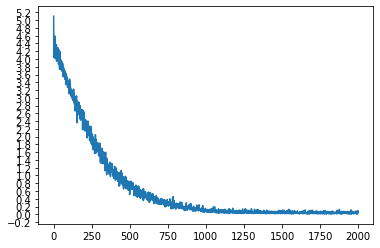

In [59]:
# Training
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 200000, print_every=5000)

In [60]:
sentence = '안녕 내 이름은 톰이고 너는 사과야?'
sentence = ' '.join([word[0] for word in token.pos(sentence)])
sentence

'안녕 내 이름 은 톰 이고 너 는 사과 야 ?'

### model save

In [ ]:
torch.save({
    'encoder' : encoder1.state_dict(),
    'decoder' : attn_decoder1.state_dict()},
    '/content/drive/MyDrive/Colab Notebooks/코드 실습/model_save/seq2seq_attn')

### visualization

In [53]:
plt.rcParams['font.family'] = 'NanumGothic'

input = 저녁은 먹었어 점심은 안먹었어 너는?
output = when you're in australia now ? <EOS>


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51200 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45377 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47673 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50632 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_

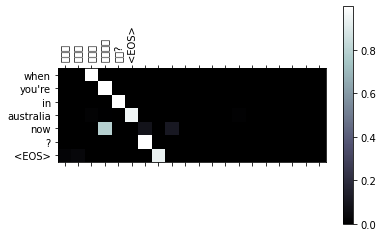

In [62]:
evaluateAndShowAttention("저녁은 먹었어 점심은 안먹었어 너는?")